In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# What do we want to do here?
# Figure out the "least incomplete" dataset for analysis
# Categorise variables for treatment 

In [3]:
# BES = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.3.dta")

In [4]:
%%time
BES = pd.read_stata("../BES_analysis_data/BES2015_W8_Panel_v1.3.dta")
# (56190, 3637)
 
counts = BES.count() # super slow!
counts_by_individuals = BES.count(axis=1) # lets see

Wall time: 7min 8s


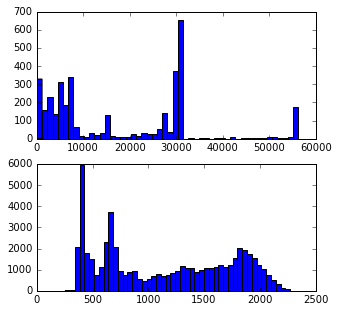

In [5]:
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=50)
axarr[1].hist(counts_by_individuals,bins=50)
print("")
# counts.hist(bins=50)
# counts_by_individuals.hist(bins=50)

In [6]:
BES.shape

(56190, 3637)

In [7]:
var_types = BES.dtypes

In [8]:
var_types.value_counts()

category          3403
object             141
float64             60
datetime64[ns]      18
int8                13
int32                1
float32              1
dtype: int64

In [9]:
BES.columns[var_types=="category"]

Index(['country', 'ukCitizenW1', 'euCitizenW1', 'commonwealthCitizenW1',
       'otherCitizenW1', 'miiW1', 'bestOnMIIW1', 'turnoutUKGeneralW1',
       'turnoutUKGeneralW2', 'turnoutUKGeneralW3',
       ...
       'polKnowMay', 'polKnowBercow', 'subjectHE', 'subjectHECurrent',
       'edlevel', 'validatedTurnoutW6', 'profile_turnout_2015',
       'profile_past_vote_2015', 'lr_scale', 'al_scale'],
      dtype='object', length=3403)

In [11]:
# int32:           'id' - dataframe id!
# float32:         'miilabelcertaintyW6' - looks like 0-1 rating on their automatic label assignment
# int8:            'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'wave6', 'wave7', 'wave8', 'wave9', 'w2full', 'w2core', 'w1full', 'w1core'
#         - 0/1 semaphore flags

# datetime64[ns]:  'starttimeW1', 'endtimeW1', 'starttimeW2', 'endtimeW2', 'starttimeW3', 'endtimeW3', 'starttimeW4', 'endtimeW4', 'starttimeW5', 'endtimeW5', 'enddateW5', 'starttimeW6', 'endtimeW6', 'starttimeW7', 'endtimeW7', 'respdateW8', 'starttimeW8', 'endtimeW8'
#         - this is when individuals *actually did* the online survey

# float64:         'wt_core_W3', 'wt_core_W4', 'wt_core_W5', 'wt_core_W6', 'wt_core_W7', 'wt_core_W8', 'wt_core_W1', 'wt_core_W2', 'wt_full_W3',
#       'wt_full_W1W2W3', 'wt_full_W4', 'wt_full_W1W2W3W4', 'wt_full_W5', 'wt_full_W1W2W3W4W5', 'wt_full_W4W5', 'wt_full_W6',
#       'wt_full_W1W2W3W4W5W6', 'wt_full_W4W5W6', 'wt_full_W4W6', 'wt_full_W7',
#       'wt_full_W8', 'wt_full_W1W2W3W4W5W6W7W8', 'wt_full_W7W8', 'wt_full_W1',
#       'wt_full_W2', 'wt_full_W1W2', 'wt_full_W1W2W3W4W5W6W7', 'wt_daily_W5',
#       'generalElecCertaintyW1', 'generalElecCertaintyW2', 'mapNamesW3',
#       'generalElecCertaintyW3', 'w3full', 'w3core', 'w4full', 'w4core',
#       'CampaignDayW5', 'w5full', 'w5core', 'w6full', 'w6core', 'w7full',
#       'w7core', 'DailyweightW8', 'riskScaleW8', 'w8full', 'w8core', 'w9full',
#       'w9core', 'miilabelcertaintyW1', 'miilabelcertaintyW4',
#       'miilabelcertaintyW3', 'miilabelcertaintyW2', 'miilabelcertaintyW5',
#       'pano', 'personality_agreeableness', 'personality_conscientiousness',
#       'personality_extraversion', 'personality_neuroticism',
#       'personality_openness'
#         - demographic weightings
#         - generalElecCertainty - just 1.0 or NaN ??? - no correspondence with the survey question (scale 1-7)
#         - miilabelcertainty - same as above
#         - integers, constituency id (http://election.pressassociation.com/Constituencies/general.php)
#                      - here's an excel file with pano no vs "name" http://www.britishelectionstudy.com/custom/uploads/2016/03/BES-2015-General-Election-results-file-v2.1.xlsx
#         - personality* - integers 0-10 (big 5 personality measures)
#         - mapNamesW3 ??? integers, 0-10000 - looks maybe logarithmically distributed
#         - riskScaleW8 ??? integers, 1-16 - not even much correlation with "riskTakingW8" (.25)
#

In [12]:
# objects (text)

#        'MIIEU_textW7', 'MIIEU_textW8', 'MII_textW1', 'MII_textW2',
#        'MII_textW3', 'MII_textW4', 'MII_textW5', 'MII_textW6', 'MII_textW7',
#        'MII_textW8', 'ReasonForvoteOthW6', 'bestOnMIIOthW1', 'bestOnMIIOthW2',
#        'bestOnMIIOthW3', 'bestOnMIIOthW4', 'bestOnMIIOthW5', 'bestOnMIIOthW6',
#        'bestOnMIIOthW7', 'bestOnMIIOthW8', 'contactMPSubjectW4',
#        'euExpLeaveNegW7', 'euExpLeavePosW7', 'euExpRemainNegW7',
#        'euExpRemainPosW7', 'euRefLA', 'euroElectionVoteOthW1',
#        'euroElectionVoteOthW2', 'euroElectionVoteYoungOthW2',
#        'generalElectionVoteOthW1', 'generalElectionVoteOthW2',
#        'generalElectionVoteOthW3', 'generalElectionVoteOthW4',
#        'generalElectionVoteOthW5', 'generalElectionVoteOthW6',
#        'generalElectionVoteOthW7', 'generalElectionVoteOthW8',
#        'generalElectionVoteOthwishW6', 'generalElectionVotePostOthW5',
#        'internet1_1W4', 'internet1_1W5', 'internet1_1W8', 'internet2_1W4',
#        'internet2_1W5', 'internet2_1W8', 'internet3_1W4', 'internet3_1W5',
#        'internet3_1W8', 'knowMPOthW1', 'knowMPOthW2', 'knowMPOthW3',
#        'localElectionVoteOthW2', 'localElectionVoteOthW6',
#        'localElectionVoteOthW7', 'localElectionVoteOthW8', 'mpNameW4',
#        'onscode', 'othContactW1', 'othContactW2', 'othContactW3',
#        'othContactW4', 'othContactW5', 'othContactW6', 'othContactW7',
#        'othContactW8', 'othMpPartyW4', 'othSubjClass', 'paper1_1W4',
#        'paper1_1W5', 'paper1_1W8', 'paper2_1W4'
#        'paper2_1W8', 'paper3_1W4', 'paper3_1W5', 'paper3_1W8', 'partyIdOthW1',
#        'partyIdOthW2', 'partyIdOthW3', 'partyIdOthW4', 'partyIdOthW6',
#        'partyIdSqueezeOthW1', 'partyIdSqueezeOthW2', 'partyIdSqueezeOthW3',
#        'partyIdSqueezeOthW4', 'partyIdSqueezeOthW5', 'partyIdSqueezeOthW6',
#        'partyIdSqueezeOthW7', 'partyIdSqueezeOthW8', 'partyMemberNowOthW6',
#        'partyMemberNowOthW8', 'partyMemberPastOthW6', 'partyMemberPastOthW8',
#        'partySiteOthNameW4', 'partySiteOthNameW5', 'pcon', 'pidW2',
#        'radio1_1W4', 'radio1_1W5', 'radio1_1W8', 'radio2_1W4', 'radio2_1W5',
#        'radio2_1W8', 'radio3_1W4', 'radio3_1W5', 'radio3_1W8',
#        'recallVote15OthW7', 'scotElectionVoteConstOthW1',
#        'scotElectionVoteConstOthW2', 'scotElectionVoteConstOthW3',
#        'scotElectionVoteConstOthW4', 'scotElectionVoteConstOthW6',
#        'scotElectionVoteConstOthW7', 'scotElectionVoteConstOthW8',
#        'scotElectionVoteListOthW3', 'scotElectionVoteListOthW6',
#        'scotElectionVoteListOthW7', 'scotElectionVoteListOthW8', 'tv1_1W4',
#        'tv1_1W5', 'tv1_1W8', 'tv2_1W4', 'tv2_1W5', 'tv2_1W8', 'tv3_1W4',
#        'tv3_1W5', 'tv3_1W8', 'welshElectionVoteConstOthW1',
#        'welshElectionVoteConstOthW2', 'welshElectionVoteConstOthW3',
#        'welshElectionVoteConstOthW4', 'welshElectionVoteConstOthW6',
#        'welshElectionVoteConstOthW7', 'welshElectionVoteConstOthW8',
#        'welshElectionVoteListOthW1', 'welshElectionVoteListOthW2',
#        'welshElectionVoteListOthW3', 'welshElectionVoteListOthW7',
#        'welshElectionVoteListOthW8', 'whichPartiesHelpOthW6',
#        'whichPartyOthW4', 'whichPartyOthW5'

In [13]:
# category 3403!

In [14]:
#BES[BES.columns[var_types=="category"]].stack().value_counts()

In [18]:
# tuple_list = []
# for col in BES.columns[var_types=="category"]:
#     print(col)
#     cats = list(BES[col].cat.categories)
#     str_cat = [str(i) for i in cats]
#     tuple_list.append( "|".join(str_cat) )
        
        


#BES.loc[0,BES.columns[var_types=="category"]].apply(lambda x: tuple(x.cat.categories))

In [19]:
# cat_list = pd.DataFrame(tuple_list).stack().value_counts()

In [20]:
# len(tuple_list)

In [20]:
# cat_list = pd.DataFrame(tuple_list)

In [22]:
# cat_list.shape

In [23]:
# BES.columns[var_types=="category"].shape

In [24]:
# BES["genTrustW7"].cat.categories

In [15]:
# tuple_frame = pd.DataFrame(tuple_list)

# BES.columns[tuple_frame[tuple_frame[0]=="No|Don't know"].index]

In [16]:
# "|".join(BES.columns[var_types=="category"][cat_list[0]=="No|Don't know"])

In [17]:
# a = cat_list[0].value_counts()

In [28]:
# (a.shape, sum(a))

In [29]:
# a[0:10]


In [30]:
# b = [i for i in a.index if len(i) <150]
# c = [i for i in a.index if len(i) >=150]

In [31]:
# category_frame = pd.DataFrame([ a.index,a,[len(i) for i in a.index],[len(i.split("|")) for i in (a.index)],["|".join(BES.columns[var_types=="category"][cat_list[0]==i]) for i in (a.index) ] ] ).T
# category_frame.columns = ["question","frequency","question_length","question_options","column_name"]
# # category_frame
# category_frame.to_csv("question_categories_correct.csv")


In [32]:
# category_frame = pd.DataFrame([ a.index,a,[len(i) for i in a.index],[len(i.split("|")) for i in (a.index)],["|".join(BES.columns[var_types=="category"][cat_list[0]==i]) for i in (a.index) ] ] ).T
# category_frame.columns = ["question","frequency","question_length","question_options","column_name"]
# category_frame

In [33]:
# No, I do not know any such person,Yes, I know such a person and could reach them by the internet,
      # Yes, I know such a person and could reach them in other ways,
      # Yes, I know such a person and could reach them by internet and in other ways,Don't know             18
        








# United States Secretary of State,President of France,Prime Minister of Israel,Secretary General of the United Nations,
      # Prime Minister of Canada,Don't know
# The Welsh Assembly,The UK Parliament,Other,Don't know      34
# The Scottish Parliament,The UK Parliament,Other,Don't know 30
# North East,North West                                      20


In [34]:
# types
# 1 - linear category, just use  (some made linear by dropping "Weasel_answers")
# 2 - categories need to be modified - order changed
# 3 - set of non-ordered options
# 4 - indirect variables - did someone fill something in in the free text box or not?
# 5 - categories need to modified - things removed
# 6 - categories are integers - should maybe be transformed directly into numbers (mostly "how much money do people need minimum/well off"?)


In [35]:
# Weasel_answers = ["Don't know", 'Do\x92t know', 'Dont know', 'Donât know', "Prefer not to say", "Prefer not to answer", "Refused", "Unknown", "Neither", "Other", "I would/will not vote", "Will not vote", "I would not vote", "It depends", "Other", "Don’t follow politics on Facebook", "Don't follow politics on twitter", "9999.0", "997.0", "Yes, other", "Haven't thought about it", "There wasn't a local election in my area", "No, haven't received it", "I don't know what was negotiated", "I never received a response", "There are not local elections in my area", "Can't remember", "Varies too much to say" ]

# 9999.0 Woops!
# 99.0
# - has some overlap between being used as "don't know" in debateThreeWatchW8/debateFourWatchW8/debatefiveWatchW8
# and other columns - on balance, better to leave out until you remove these individually (we're talking about 5,000 /50,000 entries)

In [36]:

# I would not vote,Conservative,Labour,Liberal Democrat,Scottish National Party (SNP),Plaid Cymru,
        # United Kingdom Independence Party (UKIP),Green Party,British National Party (BNP),Other,Don't know            10
# Conservative,Labour,Liberal Democrat,Scottish National Party (SNP),Plaid Cymru,United Kingdom Independence Party (UKIP),
        # Green Party,British National Party (BNP),Other,No - none,Don't know                                           10
# Conservative,Labour,Liberal Democrat,Scottish National Party (SNP),Plaid Cymru,United Kingdom Independence Party (UKIP),
        # Green Party,Other,No - none,Don't know                                                                         4
# I would not vote,Conservative,Labour,Liberal Democrat,Scottish National Party (SNP),Plaid Cymru,
        # United Kingdom Independence Party (UKIP),Green Party,Other,Don't know                                          2
# Conservative,Labour,Liberal Democrat,Scottish National Party (SNP),Plaid Cymru,United Kingdom Independence Party (UKIP),
        # Green Party,British National Party (BNP),Other,Don't know                                                      2
# No party is best able to handle this issue,Conservative,Labour,Liberal Democrat,Scottish National Party (SNP), Plaid Cymru,
        # United Kingdom Independence Party (UKIP),Green Party,British National Party (BNP),Other party,Don't know       1
# England,Scotland,Wales  



# Stay/remain in the EU,Leave the EU,I would/will not vote,Don't know                               1
# Taxes collected across the UK as a whole,Taxes collected in Scotland only,It depends,Don't know   1                                                                         1
# Will vote no,Will vote 'Yes',Will not vote,Don't know                                             1
# Issue stated,None,Don't know                                                                      1
# Bad for Britain,Good for Britain,Neither,Don't know                                               2
# Bad time to buy,Good time to buy,Neither good nor bad time to buy,Don't know                      1

In [37]:
# CONFUSING VARIABLES
# mapPCW3 ??? '0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21.0|22.0|23.0|24.0|25.0|26.0|27.0|28.0|29.0|30.0|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|99|100|Don't know'

In [38]:
# load question_categories_correct.csv
# sanity check by type!
# turn into list of variables by type
# 1, 5 handled the same way -> cat.codes
# 6 -> int()
# 4 ignored
# 3 ignored for now (-> vectorized?)
# 2 direct modification

In [10]:
variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

# flipping list
var_cat_dict = dict()
for typ in [1,2,3,4,5,6]:

    e = variable_categories[variable_categories.type==typ]["column_name"].values

    var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]
    
var_cat_dict

{1: ['responsibleDebtConservativesW1',
  'responsibleDebtLiberalDemsW1',
  'responsibleDebtLabourW1',
  'responsibleDebtUKBanksW1',
  'responsibleDebtGlobalBanksW1',
  'responsibleDebtTradeUnionsW1',
  'responsibleDebtEUW1',
  'responsibleDebtOtherW1',
  'responsibleDebtNoneW1',
  'responsibleEconConservativesW1',
  'responsibleEconLibDemsW1',
  'responsibleEconLabourW1',
  'responsibleEconScottishGovtW1',
  'responsibleEconWelshGovtW1',
  'responsibleEconNoneW1',
  'responsibleNHSConservativesW1',
  'responsibleNHSLibDemsW1',
  'responsibleNHSLabourW1',
  'responsibleNHSScottishGovtW1',
  'responsibleNHSWelshGovtW1',
  'responsibleNHSNoneW1',
  'responsibleEducationConW1',
  'responsibleEducationLDW1',
  'responsibleEducationLabW1',
  'responsibleEducationScotGovtW1',
  'responsibleEducationWelshGovtW1',
  'responsibleEducationNoneW1',
  'responsibleCostLiveConW1',
  'responsibleCostLiveLDW1',
  'responsibleCostLiveLabW1',
  'responsibleCostLiveScotGovtW1',
  'responsibleCostLiveWelsh

In [11]:
var_type = pd.DataFrame(columns = ['type'] )
# df = DataFrame(columns=('lib', 'qty1', 'qty2'))
for col in BES.columns:
    dt = BES[col].dtype.name
    if ( dt!='category' ) and ( dt!='float64' ):
        var_type.loc[col] = -1
    
    elif ( dt=='float64' ) and (col in ['personality_agreeableness', 'personality_conscientiousness','personality_extraversion', 'personality_neuroticism','personality_openness','mapNamesW3','riskScaleW8']):
        var_type.loc[col] = 0

    elif ( dt=='float64' ):
        var_type.loc[col] = -1

    elif ( dt=='category' ):
        for typ in [1,2,3,4,5,6]:
            if col in var_cat_dict[typ]:
                var_type.loc[col] = typ

    else:
        print("what's up with this? " + col)
var_type["type"] = var_type["type"].astype("int8")
var_type

,type
id,-1
wt_core_W3,-1
wt_core_W4,-1
wt_core_W5,-1
wt_core_W6,-1
wt_core_W7,-1
wt_core_W8,-1
wt_core_W1,-1
wt_core_W2,-1
wt_full_W3,-1


In [12]:
%%time
# changing the order of some sets of categories
change_cat_dict = {"Bad time to buy|Good time to buy|Neither good nor bad time to buy|Don't know": ["Bad time to buy", "Neither good nor bad time to buy", "Good time to buy"],
                   "Larger|Smaller|About the same|Don't know": ["Larger", "About the same", "Smaller"],
                   "Mainly leave|Mainly remain|Fairly evenly split|Don't know": ["Mainly leave", "Fairly evenly split", "Mainly remain"],
                   'An individual share in a company|A portfolio of different company shares|The risk is the same|Don\x92t know|Prefer not to say': ['An individual share in a company', 'The risk is the same', 'A portfolio of different company shares'],
                   "No, I have never been a member|Yes, I am a member of a party|I am not a member now but I used to be|Don't know": ['No, I have never been a member', 'I am not a member now but I used to be', 'Yes, I am a member of a party'],
                   "Never or practically never|Less often than once a year|Less often but at least once a year|Less often but at least twice a year|Less often but at least once a month|Less often but at least once in two weeks|Once a week or more|Varies too much to say|I am not religious|Don't know": ['I am not religious', 'Never or practically never', 'Less often than once a year', 'Less often but at least once a year', 'Less often but at least twice a year', 'Less often but at least once a month', 'Less often but at least once in two weeks', 'Once a week or more']}
                   

Weasel_answers = ["Don't know", 'Do\x92t know', 'Dont know', 'Donât know', "Prefer not to say", "Prefer not to answer", "Refused", "Unknown", "Neither", "Other", "I would/will not vote", "Will not vote", "I would not vote", "It depends", "Other", "Don’t follow politics on Facebook", "Don't follow politics on twitter", "9999.0", "997.0", "Yes, other", "Haven't thought about it", "There wasn't a local election in my area", "No, haven't received it", "I don't know what was negotiated", "I never received a response", "There are not local elections in my area", "Can't remember", "Varies too much to say" ]

# non-answer answers
Weasel_set = set(Weasel_answers) # gets rid of duplicates!




Wall time: 0 ns


In [13]:
%%time
BES_numeric = BES.copy()
pos = 0
for col in BES_numeric:
    print(100*pos/len(BES.columns))
    pos = pos + 1
    typ = var_type["type"][col]
    if (typ == -1) | (typ == 4) | (typ == 3) | (col =="id"): # skip
        continue
        #BES_numeric.drop(col,axis=1,inplace=True)
        
    
    elif (typ == 2):
        new_cat_order = change_cat_dict["|".join(BES_numeric[col].cat.categories)]
        BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
        BES_numeric[col].cat.reorder_categories( new_cat_order, inplace=True )

        BES_numeric[col] = BES_numeric[col].cat.codes
#        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan  
    
    elif (typ == 5) | (typ == 1): # (typ == 1) | 
        # remove weasel categories
        BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
        # change to numbers!
        BES_numeric[col] = BES_numeric[col].cat.codes
#        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan
        

    elif (typ == 6):

        BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
        BES_numeric[col] = BES_numeric[col].astype('float64')

# types
# -1 - anything not a category or one of the below floats
# 0 - personality measures (in steps of .5?),'mapNamesW3','riskScaleW8'
# 1 - linear category, just use  (some made linear by dropping "Weasel_answers")
# 2 - categories need to be modified - order changed
# 3 - set of non-ordered options
# 4 - indirect variables - did someone fill something in in the free text box or not?
# 5 - categories need to modified - things removed
# 6 - categories are integers - should maybe be transformed directly into numbers (mostly "how much money do people need minimum/well off"?)


# load question_categories_correct.csv
# sanity check by type!
# turn into list of variables by type
# 1, 5 handled the same way -> cat.codes
# 6 -> int()
# 4 ignored
# 3 ignored for now (-> vectorized?)
# 2 direct modification




0.0
0.027495188342040143
0.054990376684080286
0.08248556502612042
0.10998075336816057
0.13747594171020072
0.16497113005224084
0.192466318394281
0.21996150673632114
0.2474566950783613
0.27495188342040144
0.30244707176244157
0.3299422601044817
0.35743744844652187
0.384932636788562
0.41242782513060217
0.4399230134726423
0.4674182018146824
0.4949133901567226
0.5224085784987628
0.5499037668408029
0.577398955182843
0.6048941435248831
0.6323893318669233
0.6598845202089634
0.6873797085510036
0.7148748968930437
0.7423700852350839
0.769865273577124
0.7973604619191641
0.8248556502612043
0.8523508386032445
0.8798460269452846
0.9073412152873247
0.9348364036293648
0.962331591971405
0.9898267803134452
1.0173219686554853
1.0448171569975255
1.0723123453395655
1.0998075336816058
1.1273027220236458
1.154797910365686
1.1822930987077263
1.2097882870497663
1.2372834753918065
1.2647786637338465
1.2922738520758867
1.3197690404179268
1.347264228759967
1.3747594171020072
1.4022546054440472
1.4297497937860875
1.

In [14]:
BES_numerics_only = BES_numeric[ BES_numeric.columns[ (var_type["type"]==0) | (var_type["type"]==1) | (var_type["type"]==2) | (var_type["type"]==5) | (var_type["type"]==6)  ] ]

BES_numerics_only.replace(-1,np.nan, inplace=True)
# gender only column that has no nan -> still an int

C:\ANACON~1\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [54]:
BES_numeric.to_csv("..\BES_analysis_data\W_8Panel_semi_cleaned.csv")

In [1]:
#BES_numeric.to_hdf("..\BES_analysis_data\W_8Panel_semi_cleaned.hdf",'W8_Panel_semi_cleaned')

In [64]:
# var_type["type"]["id"]=0

BES_numerics_only = BES_numeric[ BES_numeric.columns[ (var_type["type"]==0) | (var_type["type"]==2) | (var_type["type"]==1) | (var_type["type"]==5) | (var_type["type"]==6)  ] ]


In [33]:
import gc
gc.collect()

21

In [67]:
BES_numerics_only.to_hdf("..\BES_analysis_data\W8Panel_numerics_only.hdf",'W8_Panel_numerics_only')

In [70]:
euRefcols = [s for s in list(BES_numerics_only.columns) if "euRef" in s]

In [71]:
BES_numerics_only[euRefcols].count()

euRefVoteW1             25121
euRefVoteW2             21660
euRefVoteW3             23358
euRefVoteW4             26287
euRefVoteW6             25239
euRefTurnoutW7          30217
euRefVoteW7             28044
euRefVoteSqueezeW7       4180
euRefInterestW7         30392
euRefExpectationW7      26414
euRefFinalW7            24754
euRefVoteUnsqueezeW7    26178
euRefVotePostW8          3929
euRefTurnoutW8          26871
euRefVoteW8             29065
euRefVoteSqueezeW8       1164
euRefCertaintyW8        25966
euRefInterestW8         31011
euRefExpectationW8      26700
euRefFinalW8            25391
euRefVoteUnsqueezeW8    23746
euRefVote2W8            25136
dtype: int64

In [72]:
corr = BES_numerics_only.corr()

In [73]:
corr

,id,ukCitizenW1,euCitizenW1,commonwealthCitizenW1,otherCitizenW1,turnoutUKGeneralW1,turnoutUKGeneralW2,turnoutUKGeneralW3,turnoutUKGeneralW4,turnoutUKGeneralW5,...,selfNumEmployeesLast,fatherNumEmployees,motherNumEmployees,selfOccStatus,selfOccStatusLast,riskTaking,edlevel,profile_turnout_2015,lr_scale,al_scale
id,1.000000,-0.056471,0.023294,0.010873,0.039779,-0.084969,-0.067219,-0.080891,-0.084525,-0.060349,...,0.114151,-0.007840,0.040579,0.033642,0.008495,0.069195,0.011555,0.107492,0.016372,-0.105072
ukCitizenW1,-0.056471,1.000000,-0.415109,-0.143099,-0.343738,0.133926,0.127701,0.117769,0.146216,0.175031,...,-0.182720,0.008150,-0.292560,0.011024,0.016325,-0.004388,-0.058059,-0.189649,-0.014356,0.049280
euCitizenW1,0.023294,-0.415109,1.000000,0.573022,0.044826,-0.030004,-0.023147,-0.019988,-0.039059,-0.049854,...,0.060386,-0.035217,0.040842,-0.010014,-0.026010,0.033759,0.097973,0.082268,0.002844,-0.140338
commonwealthCitizenW1,0.010873,-0.143099,0.573022,1.000000,0.059601,0.014440,0.021883,0.016998,0.023118,0.023499,...,-0.052522,0.016273,0.372419,-0.011538,-0.008077,0.027563,0.079724,-0.012590,0.004452,-0.102290
otherCitizenW1,0.039779,-0.343738,0.044826,0.059601,1.000000,-0.057587,-0.053101,-0.048781,-0.045215,-0.063556,...,-0.030039,-0.008879,0.085360,-0.013400,-0.001120,0.000055,0.039904,0.068404,-0.002939,-0.045119
turnoutUKGeneralW1,-0.084969,0.133926,-0.030004,0.014440,-0.057587,1.000000,0.764196,0.759704,0.723112,0.690526,...,-0.017520,-0.019017,-0.262648,-0.039750,0.010759,0.010904,0.076515,-0.485345,0.030869,-0.045580
turnoutUKGeneralW2,-0.067219,0.127701,-0.023147,0.021883,-0.053101,0.764196,1.000000,0.796294,0.749522,0.719718,...,0.007386,0.010646,-0.237520,-0.042552,0.010085,0.019315,0.071342,-0.527078,0.014381,-0.052605
turnoutUKGeneralW3,-0.080891,0.117769,-0.019988,0.016998,-0.048781,0.759704,0.796294,1.000000,0.778860,0.724834,...,0.017113,-0.018303,-0.040221,-0.037715,0.005712,0.001483,0.067543,-0.524844,0.018140,-0.045496
turnoutUKGeneralW4,-0.084525,0.146216,-0.039059,0.023118,-0.045215,0.723112,0.749522,0.778860,1.000000,0.814428,...,0.025709,-0.022035,-0.132427,-0.034667,0.005085,0.008263,0.068877,-0.584439,0.011465,-0.052182
turnoutUKGeneralW5,-0.060349,0.175031,-0.049854,0.023499,-0.063556,0.690526,0.719718,0.724834,0.814428,1.000000,...,0.009445,0.005983,-0.073295,-0.029643,0.015645,0.018301,0.079693,-0.687067,0.018062,-0.059309


In [112]:
corr["euRefVoteW8"].sort_values()[3100:]

ukCoopCAPW8                    0.560200
ptvUKIPW2                      0.565429
ukCoopWorkersW7                0.569289
ptvUKIPW3                      0.572536
immigrantsWelfareStateW8       0.574793
likeFarageW7                   0.577141
euLeaveVoiceW7                 0.579903
leaveToneW8                    0.580235
likeUKIPW2                     0.580337
likeUKIPW4                     0.584483
effectsEUTradeW7               0.587164
likeUKIPW6                     0.594150
likeUKIPW5                     0.597512
ukCoopWorkersW8                0.600504
ptvUKIPW7                      0.603631
effectsEUWorkersW8             0.603811
socialIdentityGlobalLeaveW7    0.603831
EUIntegrationSelfW2            0.603946
EUIntegrationSelfW1            0.606119
likeUKIPW3                     0.608396
likeFarageW8                   0.611125
euParlOverRideW7               0.613996
UKsovereigntyW7                0.618010
socialIdentityGlobalLeaveW8    0.619507
likeUKIPW7                     0.620245


In [103]:
corr["euRefVoteW8"]["gayEquality"]

0.33096998135705796

In [126]:
clean_feature_set_nonan = BES_numerics_only.fillna(BES_numerics_only.mean())